In [20]:
import jupyter

In [21]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import gymnasium as gym
import matplotlib.pyplot as plt
import ace_tools_open as tools

from src.utils.system import boot
from src.defaults import RANDOM_SEEDS, TOP2_STOCK_BY_SECTOR
from tracker import OHLCV_DF, EpisodeTracker, EnvironmentTracker, AgentTracker

In [22]:
import pandas as pd
from datetime import datetime, timedelta

# Define o intervalo de tempo para coleta dos dados
end_date = datetime.today()
start_date = end_date - timedelta(days=15 * 365)  # aproximadamente 15 anos

# Lista de ativos a serem coletados (tickers padrão da Alpaca)
tickers = ['SPY', 'VIXY', 'TLT', 'GLD', 'UUP']

# Apenas exibindo os parâmetros de coleta para validação inicial
{
    "tickers": tickers,
    "start_date": start_date.strftime('%Y-%m-%d'),
    "end_date": end_date.strftime('%Y-%m-%d'),
    "frequency": "daily"
}



{'tickers': ['SPY', 'VIXY', 'TLT', 'GLD', 'UUP'],
 'start_date': '2010-06-24',
 'end_date': '2025-06-20',
 'frequency': 'daily'}

In [23]:
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame


# Suas credenciais da Alpaca
ALPACA_API_KEY = "PKA39AR3MEBWO2G0E2LG"
ALPACA_API_SECRET = "9JvPEgszc02RIFIsk3iVED2oSz5AUvVEVHT21Szq"
BASE_URL = "https://paper-api.alpaca.markets"

# Inicializa o cliente da Alpaca
api = client = StockHistoricalDataClient(ALPACA_API_KEY, ALPACA_API_SECRET)

# Função para coletar dados históricos de um ativo
def fetch_data(symbol, start, end):
    request_params = StockBarsRequest(
        symbol_or_symbols=symbol,
        timeframe=TimeFrame.Day,
        start=start,
        end=end,
        adjustment='raw'
    )
    bars = client.get_stock_bars(request_params).df
    
    #barset = barset[barset['symbol'] == symbol].copy()
    #barset.drop(columns=['symbol'], inplace=True)
    #barset.index = barset.index.tz_localize(None)
    return bars

# Coletar dados de todos os ativos
data_dict = {}
for ticker in tickers:
    try:
        data = fetch_data(ticker, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
        data_dict[ticker] = data
    except Exception as e:
        data_dict[ticker] = None
        print(f"Erro ao coletar {ticker}: {e}")

# Exibir um resumo dos dados coletados
{ticker: df.shape if df is not None else None for ticker, df in data_dict.items()}



{'SPY': (2379, 7),
 'VIXY': (2379, 7),
 'TLT': (2379, 7),
 'GLD': (2379, 7),
 'UUP': (2379, 7)}

In [24]:
EXPERIMENT_NAME = "regime_detection_v1"
EXPERIMENT_PATH = "data/experiments/"+EXPERIMENT_NAME+'/'

In [27]:
#for s in ['SPY','VIXY','TLT','GLD','UUP']:
#    data_dict[s].to_csv(f'{EXPERIMENT_PATH}{s}.csv')
import os

# Caminhos dos arquivos
file_paths = {
    'SPY': f'{EXPERIMENT_PATH}SPY.csv',
    'VIXY': f'{EXPERIMENT_PATH}VIXY.csv',
    'TLT': f'{EXPERIMENT_PATH}TLT.csv',
    'GLD': f'{EXPERIMENT_PATH}GLD.csv',
    'UUP': f'{EXPERIMENT_PATH}UUP.csv'
}
file_paths

{'SPY': 'data/experiments/regime_detection_v1/SPY.csv',
 'VIXY': 'data/experiments/regime_detection_v1/VIXY.csv',
 'TLT': 'data/experiments/regime_detection_v1/TLT.csv',
 'GLD': 'data/experiments/regime_detection_v1/GLD.csv',
 'UUP': 'data/experiments/regime_detection_v1/UUP.csv'}

In [28]:


import numpy as np

# Padronizar e preparar todos os dataframes
dfs = []
for ticker, path in file_paths.items():
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['timestamp']).dt.date
    df = df[['date', 'open', 'high', 'low', 'close', 'volume']]
    df.columns = ['date', f'open_{ticker}', f'high_{ticker}', f'low_{ticker}',
                  f'close_{ticker}', f'volume_{ticker}']
    dfs.append(df)

# Merge dos dados por data
from functools import reduce
df_merged = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), dfs)
df_merged = df_merged.sort_values('date').reset_index(drop=True)
df_merged = df_merged.dropna().copy()

# Calcular retornos log para SPY e indicadores básicos
df_merged['return_SPY'] = np.log(df_merged['close_SPY'] / df_merged['close_SPY'].shift(1))
df_merged['vol_SPY'] = df_merged['return_SPY'].rolling(10).std()
df_merged['spy_vixy_ratio'] = df_merged['close_SPY'] / df_merged['close_VIXY']
df_merged['spy_tlt_ratio'] = df_merged['close_SPY'] / df_merged['close_TLT']
df_merged['spy_gld_ratio'] = df_merged['close_SPY'] / df_merged['close_GLD']
df_merged['spy_uup_ratio'] = df_merged['close_SPY'] / df_merged['close_UUP']

# Drop de valores iniciais nulos causados por rolling
df_merged = df_merged.dropna().reset_index(drop=True)

# Exibir prévia para validação antes de aplicar MSM
tools.display_dataframe_to_user(name="Prévia com Features Técnicas", dataframe=df_merged.head(10))

Prévia com Features Técnicas


Loading ITables v2.4.0 from the internet... (need help?)


In [29]:
#Markov Switching Model (MSM) aos retornos do SPY para detectar regimes históricos latentes como: bullish, bearish, volatil
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Aplicar o MSM com 3 regimes nos retornos do SPY
model = MarkovRegression(df_merged['return_SPY'], k_regimes=3, trend='c', switching_variance=True)
msm_result = model.fit()

# Adicionar os regimes detectados ao dataframe
df_merged['regime'] = msm_result.smoothed_marginal_probabilities.idxmax(axis=1)

# Resumo estatístico dos regimes
regime_summary = df_merged.groupby('regime')['return_SPY'].agg(['mean', 'std', 'count'])

tools.display_dataframe_to_user(name="Resumo Estatístico dos Regimes (MSM)", dataframe=regime_summary)


Resumo Estatístico dos Regimes (MSM)


Loading ITables v2.4.0 from the internet... (need help?)


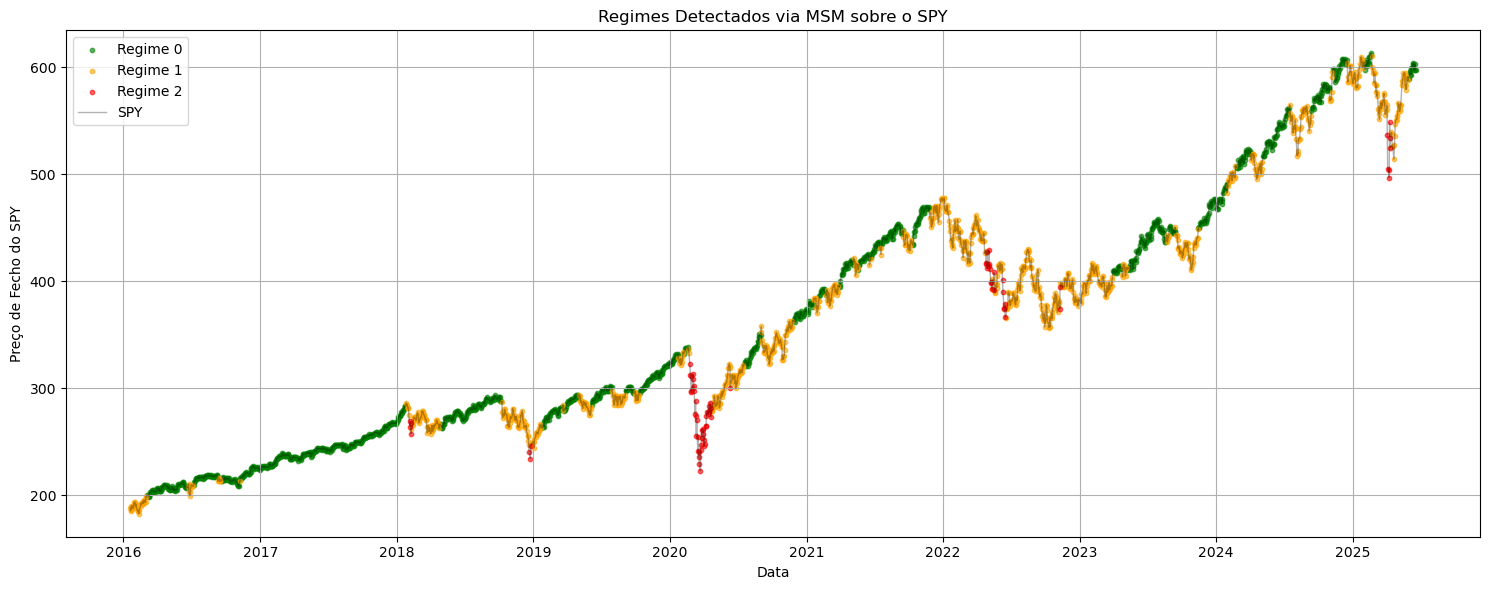

In [30]:
import matplotlib.pyplot as plt

# Plot dos regimes ao longo do tempo
plt.figure(figsize=(15, 6))
colors = {0: 'green', 1: 'orange', 2: 'red'}
for regime, color in colors.items():
    subset = df_merged[df_merged['regime'] == regime]
    plt.scatter(subset['date'], subset['close_SPY'], label=f'Regime {regime}', s=10, color=color, alpha=0.6)

plt.plot(df_merged['date'], df_merged['close_SPY'], color='black', alpha=0.3, linewidth=1, label='SPY')
plt.title("Regimes Detectados via MSM sobre o SPY")
plt.xlabel("Data")
plt.ylabel("Preço de Fecho do SPY")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb
import numpy as np

# Etapas de parametrização
n_future = 5  # dias no futuro para detectar mudança de regime
m_history = 10  # dias anteriores como base

# Criar coluna binária: haverá mudança de regime nos próximos n dias?
regimes = df_merged['regime'].values
will_change = np.zeros(len(regimes))
for i in range(len(regimes) - n_future):
    if not all(regimes[i] == regimes[i+1:i+n_future+1]):
        will_change[i] = 1
df_merged['will_change_regime'] = will_change

# Features usadas (últimos m dias agregados)
feature_cols = ['return_SPY', 'vol_SPY', 'spy_vixy_ratio',
                'spy_tlt_ratio', 'spy_gld_ratio', 'spy_uup_ratio']

# Criar dataset supervisionado
X, y = [], []
dates = []

for i in range(m_history, len(df_merged) - n_future):
    window = df_merged.iloc[i - m_history:i]
    features = window[feature_cols].agg(['mean', 'std', 'min', 'max']).values.flatten()
    X.append(features)
    y.append(df_merged['will_change_regime'].iloc[i])
    dates.append(df_merged['date'].iloc[i])

X = np.array(X)
y = np.array(y)



# Separar treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Calcular proporção inversa para balanceamento (n_neg / n_pos)
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Treinar XGBoost com penalização de classe minoritária
model_balanced = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=3,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=pos_weight
)
model_balanced.fit(X_train, y_train)

# Previsões com modelo balanceado
y_pred = model_balanced.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

# Resultados

# Treinar modelo XGBoost
#model = xgb.XGBClassifier(n_estimators=300, max_depth=5, use_label_encoder=False, eval_metric='logloss')
#model.fit(X_train, y_train)

# Previsões
#y_pred = model.predict(X_test)
#report = classification_report(y_test, y_pred, output_dict=True)

# Exportar previsões + datas para visualização posterior
pred_df = pd.DataFrame({
    'date': dates[-len(y_test):],
    'true_change': y_test,
    'predicted_change': y_pred
})

tools.display_dataframe_to_user(name="Resultados da Previsão de Mudança de Regime", dataframe=pred_df.tail(20))


C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [18:06:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Resultados da Previsão de Mudança de Regime


Loading ITables v2.4.0 from the internet... (need help?)


In [43]:
report


{'0.0': {'precision': 0.8146551724137931,
  'recall': 0.9921259842519685,
  'f1-score': 0.8946745562130177,
  'support': 381.0},
 '1.0': {'precision': 0.5714285714285714,
  'recall': 0.044444444444444446,
  'f1-score': 0.08247422680412371,
  'support': 90.0},
 'accuracy': 0.8110403397027601,
 'macro avg': {'precision': 0.6930418719211823,
  'recall': 0.5182852143482065,
  'f1-score': 0.48857439150857074,
  'support': 471.0},
 'weighted avg': {'precision': 0.7681787518433686,
  'recall': 0.8110403397027601,
  'f1-score': 0.7394770410393438,
  'support': 471.0}}

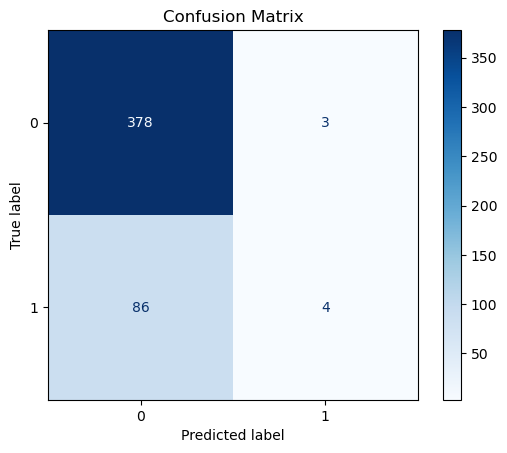

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [53]:
df_merged.info()
df_merged['vixy_pct_change']= df_merged['close_VIXY'].pct_change()
df_merged.dropna(inplace=True)
df_merged

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2369 entries, 0 to 2368
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                2369 non-null   object 
 1   open_SPY            2369 non-null   float64
 2   high_SPY            2369 non-null   float64
 3   low_SPY             2369 non-null   float64
 4   close_SPY           2369 non-null   float64
 5   volume_SPY          2369 non-null   float64
 6   open_VIXY           2369 non-null   float64
 7   high_VIXY           2369 non-null   float64
 8   low_VIXY            2369 non-null   float64
 9   close_VIXY          2369 non-null   float64
 10  volume_VIXY         2369 non-null   float64
 11  open_TLT            2369 non-null   float64
 12  high_TLT            2369 non-null   float64
 13  low_TLT             2369 non-null   float64
 14  close_TLT           2369 non-null   float64
 15  volume_TLT          2369 non-null   float64
 16  open_G

,date,open_SPY,high_SPY,low_SPY,close_SPY,volume_SPY,open_VIXY,high_VIXY,low_VIXY,close_VIXY,...,vol_SPY,spy_vixy_ratio,spy_tlt_ratio,spy_gld_ratio,spy_uup_ratio,regime,will_change_regime,rsi_14,zscore_return,vixy_pct_change
19,2016-02-16,188.77,189.81,187.63,189.78,124806967.0,18.28,18.5800,17.99,18.06,...,0.013947,10.508306,1.458612,1.653568,7.548926,1,0.0,49.259040,1.187917,-0.046463
20,2016-02-17,191.17,193.32,191.01,192.88,137936059.0,17.62,17.7900,17.25,17.33,...,0.013756,11.129833,1.491609,1.670246,7.675288,1,0.0,58.086042,1.059780,-0.040421
21,2016-02-18,193.20,193.27,191.72,192.09,103630950.0,17.21,17.5800,17.03,17.29,...,0.013754,11.109890,1.467456,1.623890,7.640811,1,0.0,55.105957,-0.422094,-0.002308
22,2016-02-19,191.17,192.18,190.45,192.00,117844861.0,17.60,17.7500,16.82,16.84,...,0.013750,11.401425,1.465593,1.632931,7.658556,1,0.0,46.511062,-0.136170,-0.026027
23,2016-02-22,193.87,194.95,193.79,194.78,110378274.0,16.36,16.4200,15.87,15.89,...,0.012522,12.258024,1.487552,1.686553,7.711006,1,0.0,52.064304,0.992563,-0.056413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,2025-06-12,600.01,603.75,599.52,603.75,64129003.0,49.94,50.2900,49.07,49.96,...,0.004679,12.084668,6.926121,1.933857,22.278598,0,0.0,72.311015,0.343391,0.016273
2365,2025-06-13,598.50,601.85,595.48,597.00,89487793.0,52.37,54.6799,50.94,53.81,...,0.006311,11.094592,6.915325,1.887508,21.972764,0,0.0,68.229061,-1.465246,0.077062
2366,2025-06-16,600.40,604.45,600.22,602.68,79984125.0,51.75,51.7500,49.62,49.81,...,0.006710,12.099578,7.052188,1.933030,22.157353,0,0.0,63.498010,1.068707,-0.074336
2367,2025-06-17,600.21,601.75,596.76,597.53,82209365.0,51.04,53.8600,50.67,52.83,...,0.007255,11.310430,6.907861,1.915529,21.823594,0,0.0,61.026103,-1.041584,0.060630


In [54]:
# Implementar cálculo manual de RSI(14)
def compute_rsi(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)

    avg_gain = up.rolling(window=period).mean()
    avg_loss = down.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Recalcular RSI manualmente
df_merged['rsi_14'] = compute_rsi(df_merged['close_SPY'], period=14)

# Repetir o resto do processo (features, dataset, XGBoost)
rolling_mean = df_merged['return_SPY'].rolling(window=20).mean()
rolling_std = df_merged['return_SPY'].rolling(window=20).std()
df_merged['zscore_return'] = (df_merged['return_SPY'] - rolling_mean) / rolling_std

# Recalcular label com n_future = 3
n_future = 3
regimes = df_merged['regime'].values
will_change = np.zeros(len(regimes))
for i in range(len(regimes) - n_future):
    if not all(regimes[i] == regimes[i+1:i+n_future+1]):
        will_change[i] = 1
df_merged['will_change_regime'] = will_change

# Novas colunas de features
feature_cols = ['return_SPY', 'vol_SPY', 'spy_vixy_ratio',
                'spy_tlt_ratio', 'spy_gld_ratio', 'spy_uup_ratio',
                'vixy_pct_change', 'rsi_14', 'zscore_return']

# Recriar dataset supervisionado
m_history = 10
X, y, dates = [], [], []

for i in range(m_history, len(df_merged) - n_future):
    window = df_merged.iloc[i - m_history:i]
    features = window[feature_cols].agg(['mean', 'std', 'min', 'max']).values.flatten()
    if not np.any(np.isnan(features)):
        X.append(features)
        y.append(df_merged['will_change_regime'].iloc[i])
        dates.append(df_merged['date'].iloc[i])

X = np.array(X)
y = np.array(y)

# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Rebalancear com scale_pos_weight
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
model_improved = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=pos_weight
)
model_improved.fit(X_train, y_train)
y_pred_improved = model_improved.predict(X_test)
report_improved = classification_report(y_test, y_pred_improved, output_dict=True)

report_improved


C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [18:14:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Francisco Sá\App

{'0.0': {'precision': 0.8841201716738197,
  'recall': 1.0,
  'f1-score': 0.9384965831435079,
  'support': 412.0},
 '1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 54.0},
 'accuracy': 0.8841201716738197,
 'macro avg': {'precision': 0.44206008583690987,
  'recall': 0.5,
  'f1-score': 0.46924829157175396,
  'support': 466.0},
 'weighted avg': {'precision': 0.7816684779605445,
  'recall': 0.8841201716738197,
  'f1-score': 0.8297437602041314,
  'support': 466.0}}

In [55]:
# Ajustar scale_pos_weight para um valor fixo mais suave
model_soft_weight = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=2  # penalização mais leve
)
model_soft_weight.fit(X_train, y_train)
y_pred_soft = model_soft_weight.predict(X_test)
report_soft = classification_report(y_test, y_pred_soft, output_dict=True)

report_soft

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [18:15:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Francisco Sá\App

{'0.0': {'precision': 0.8841201716738197,
  'recall': 1.0,
  'f1-score': 0.9384965831435079,
  'support': 412.0},
 '1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 54.0},
 'accuracy': 0.8841201716738197,
 'macro avg': {'precision': 0.44206008583690987,
  'recall': 0.5,
  'f1-score': 0.46924829157175396,
  'support': 466.0},
 'weighted avg': {'precision': 0.7816684779605445,
  'recall': 0.8841201716738197,
  'f1-score': 0.8297437602041314,
  'support': 466.0}}

C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_17084\760929586.py:23: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  plt.tight_layout()
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


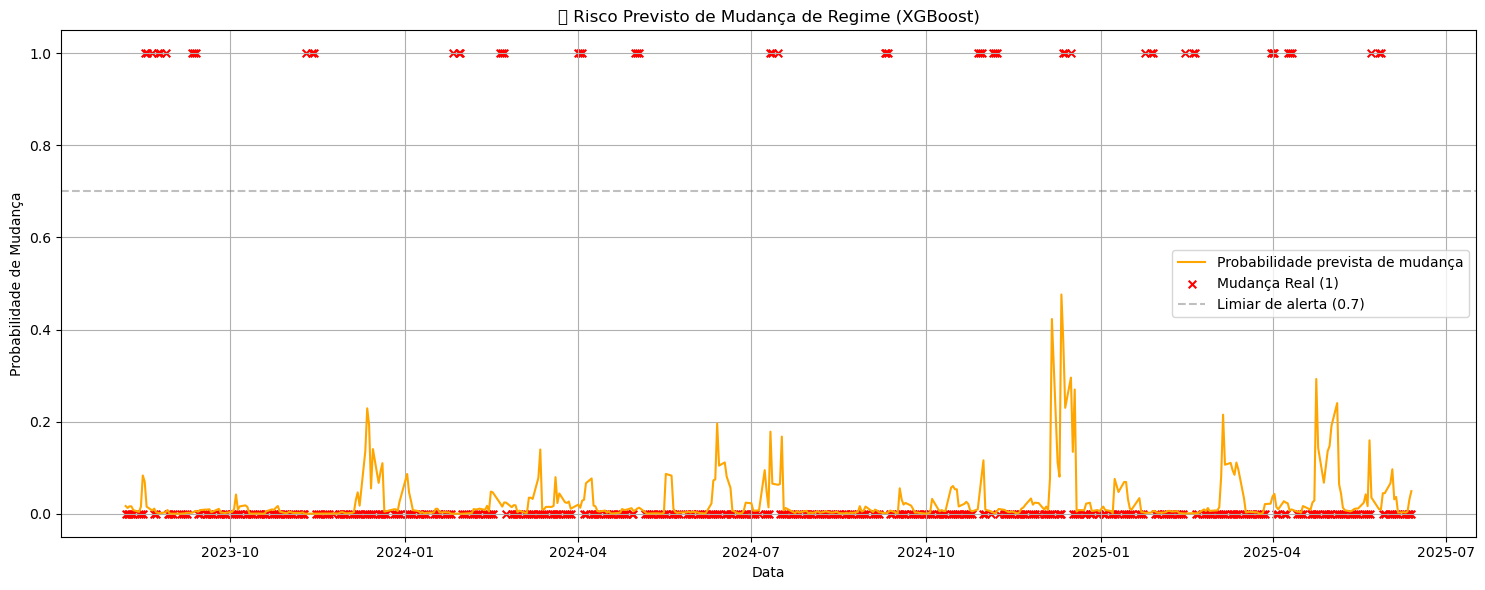

In [56]:
import matplotlib.pyplot as plt

# Obter probabilidades previstas (classe 1)
y_proba = model_soft_weight.predict_proba(X_test)[:, 1]

# Construir dataframe com data e risco previsto
risk_df = pd.DataFrame({
    'date': dates[-len(y_proba):],
    'true_change': y_test,
    'predicted_proba': y_proba
})

# Plot do risco ao longo do tempo
plt.figure(figsize=(15, 6))
plt.plot(risk_df['date'], risk_df['predicted_proba'], label='Probabilidade prevista de mudança', color='orange')
plt.scatter(risk_df['date'], risk_df['true_change'], label='Mudança Real (1)', color='red', marker='x', s=30)
plt.axhline(0.7, color='gray', linestyle='--', alpha=0.5, label='Limiar de alerta (0.7)')
plt.title("🔮 Risco Previsto de Mudança de Regime (XGBoost)")
plt.xlabel("Data")
plt.ylabel("Probabilidade de Mudança")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


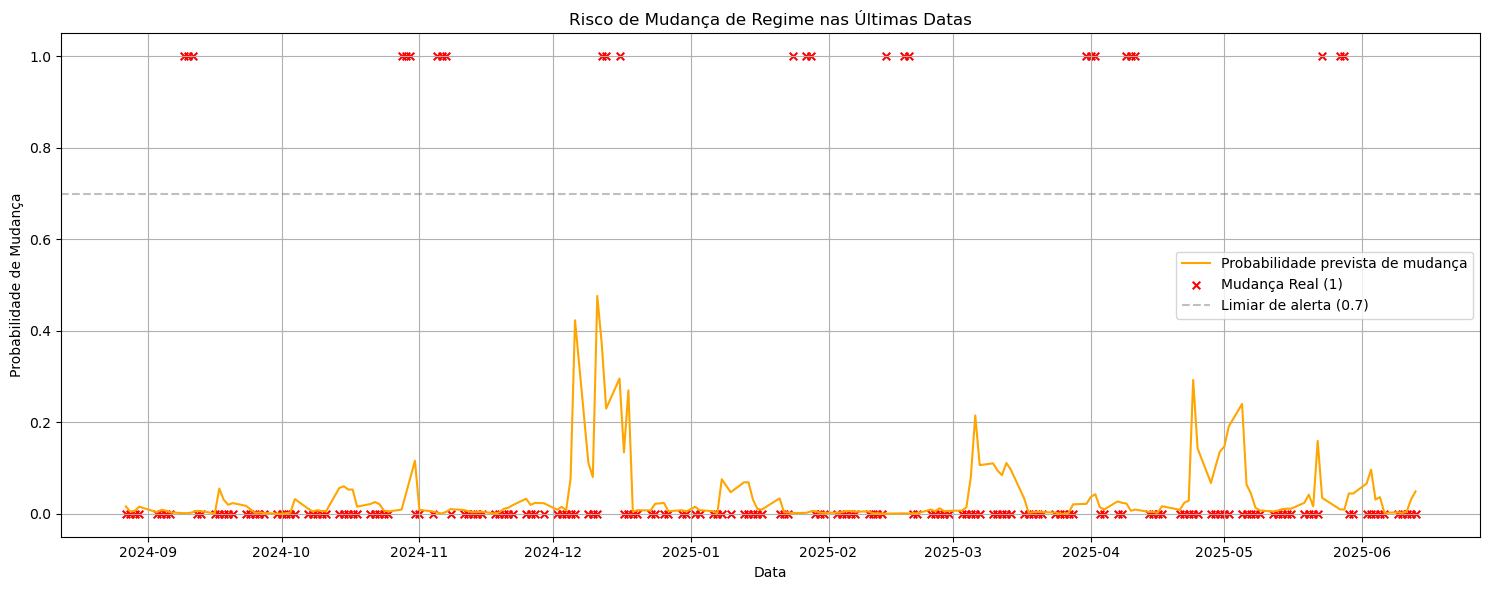

In [57]:
# Limitar às últimas 200 datas para evitar estouro de memória
risk_df_limited = risk_df.tail(200)

# Plot do risco previsto (probabilidade de regime) nas últimas datas
plt.figure(figsize=(15, 6))
plt.plot(risk_df_limited['date'], risk_df_limited['predicted_proba'],
         label='Probabilidade prevista de mudança', color='orange')
plt.scatter(risk_df_limited['date'], risk_df_limited['true_change'],
            label='Mudança Real (1)', color='red', marker='x', s=30)
plt.axhline(0.7, color='gray', linestyle='--', alpha=0.5, label='Limiar de alerta (0.7)')
plt.title("Risco de Mudança de Regime nas Últimas Datas")
plt.xlabel("Data")
plt.ylabel("Probabilidade de Mudança")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [58]:
# Exportar últimos 200 pontos de risco e mudança real
risk_df_limited = risk_df.tail(200).reset_index(drop=True)
tools.display_dataframe_to_user(name="Últimos 200 Dias – Risco de Mudança de Regime", dataframe=risk_df_limited)


Últimos 200 Dias – Risco de Mudança de Regime


Loading ITables v2.4.0 from the internet... (need help?)


In [59]:
from sklearn.ensemble import RandomForestClassifier

# Parâmetros
window_size = 200  # dias de histórico para treinar cada mini-modelo
step = 1  # predição diária
risk_scores = []
risk_dates = []

# Aplicar rolling window: em cada ponto, treinar com os últimos 200 dias e prever o seguinte
for i in range(window_size, len(X_test) - step):
    X_window = X_test[i - window_size:i]
    y_window = y_test[i - window_size:i]
    X_next = X_test[i:i + step]

    if y_window.sum() > 0:  # garantir que haja pelo menos 1 caso positivo
        model_roll = RandomForestClassifier(n_estimators=100, max_depth=4)
        model_roll.fit(X_window, y_window)
        risk = model_roll.predict_proba(X_next)[0, 1]  # risco da próxima amostra
    else:
        risk = 0.0

    risk_scores.append(risk)
    risk_dates.append(dates[-len(X_test) + i + step])

# Criar DataFrame com score de risco contínuo
rolling_df = pd.DataFrame({
    'date': risk_dates,
    'risk_score': risk_scores
})

tools.display_dataframe_to_user(name="Score Contínuo de Risco (Rolling Model)", dataframe=rolling_df.tail(200))


Score Contínuo de Risco (Rolling Model)


Loading ITables v2.4.0 from the internet... (need help?)
